In [1]:
# notebook to get started running ignition delays
# not going to use pyteck because it's too bulky for me to run 5000 and do global analysis

In [2]:
import cantera as ct
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the model
rmg_cti = '/work/westgroup/harris.se/autoscience/autoscience/butane/chem_annotated.cti'
rmg_gas = ct.Solution(rmg_cti)


# load aramco model
aramco_cti = '/work/westgroup/harris.se/autoscience/aramco/AramcoMech3.0.MECH.cti'
aramco_gas = ct.Solution(aramco_cti)

In [10]:
# load experimental data
ignition_delay_data = '../butane/butane_ignition_delay.csv'
df = pd.read_csv(ignition_delay_data)

# slice just table 2, where phi=0.3, p=20atm
table2 = df[df['Table'] == 2]

In [11]:
# Define Initial conditions using experimental data
tau2 = table2['time (ms)'].values.astype(float)  # ignition delay
T2 = table2['T_C'].values  # Temperatures
P2 = table2['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm

# list of starting conditions
# Mixture compositions taken from table 2 of 
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 0.3
x_diluent = 0.7821
conc_dict = {
    'O2': 0.2083,
    'C4H10': 0.00962
}
for i in range(0, len(table2)):
    
    x_N2 = table2['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table2['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table2['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['AR'] = x_Ar
    conc_dict['CO2'] = x_CO2
    
    concentrations.append(conc_dict)

In [12]:
# create empty arrays for the models
aramco_tau2 = np.zeros(len(tau2))
rmg_tau2 = np.zeros(len(tau2))

In [13]:
def run_simulation(gas, T, P, X):
    # function to run a RCM simulation

    t_end = 1.0  # time in seconds
    gas.TPX = T, P, X
    
    
    env = ct.Reservoir(ct.Solution('air.xml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    
    
    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)
    
    return (times, T, P, X)

In [14]:
def get_ignition_delay(times, T, P, X, plot=False, title='', save=''):
    # look for time with largest derivative
    slopes = np.gradient(P, times)
    i = np.argmax(slopes)
    
    
    if plot:
        # plot to check if the answer makes sense
        plt.clf()
        plt.plot(times, P)
        plt.axvline(x=times[i], color='green')
        max_time = min(times[i] * 1.1, times[-1])
        plt.xlim([0, max_time])
        plt.xlabel('Time (s)')
        plt.ylabel('Pressure (Pa)')
        
        if title:
            plt.title(title)
        else:
            plt.title('Ignition Delay')
        
        if save:
            plt.savefig(save)

    
    return i, times[i]
    # look for time when it reaches half of maximum pressure


# Run the Simulations

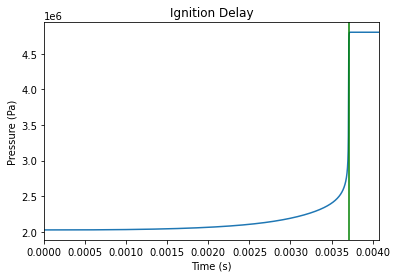

In [15]:
for i in range(0, len(table2)):
    # aramco, keep as is
    X = concentrations[i]
    t, T, P, X = run_simulation(aramco_gas, T2[i], P2[i], X)
    save_name = f'aramco_2-{i:04}.png'
    index, delay_time = get_ignition_delay(t, T, P, X, plot=True, save=save_name)
    aramco_tau2[i] = delay_time
    
    # rmg, modify 
    X = f'O2(2):{concentrations[i]["O2"]}, butane(1):{concentrations[i]["C4H10"]}, Ar:{concentrations[i]["AR"]},  CO2(7):{concentrations[i]["CO2"]}, N2:{concentrations[i]["N2"]}'
    t, T, P, X = run_simulation(rmg_gas, T2[i], P2[i], X)
    save_name = f'rmg_2-{i:04}.png'
    index, delay_time = get_ignition_delay(t, T, P, X, plot=True, save=save_name)
    rmg_tau2[i] = delay_time

# Plot All Ignition Delays

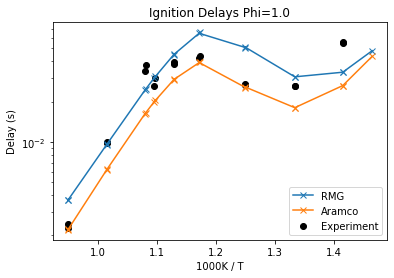

In [16]:
plt.plot(1000.0 / T2, rmg_tau2, marker='x')
plt.plot(1000.0 / T2, aramco_tau2, marker='x')
plt.scatter(1000.0 / T2, tau2 / 1000.0, color='black')
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['RMG', 'Aramco', 'Experiment'])
plt.title('Ignition Delays Phi=0.3')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table2.png')